# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

The goal of this project is to build a model that predicts the salaries of various jobs based on existing data for job descriptions at different companies and their corresponding salaries.

In [59]:
#import your libraries
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#etc

#your info here
__author__ = "Albert Ntiri"
__email__ = "albert.ntiri@gmail.com"

## Part 2 - DISCOVER

### ---- 2 Load the data ----

In [2]:
#load the data into a Pandas dataframe

train_features = pd.read_csv('data/train_features.csv')
train_salaries = pd.read_csv('data/train_salaries.csv')
test_features = pd.read_csv('data/test_features.csv')

### ---- 3 Clean the data ----

In [3]:
#look for duplicate data, invalid data (e.g. salaries <=0), or corrupt data and remove it

In [4]:
train_features.info()
# 5 categorical features, 2 numeric features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


In [6]:
train_features.degree.value_counts()

# A quarter of the data set has 'NONE' values in the degree column

HIGH_SCHOOL    236976
NONE           236854
BACHELORS      175495
DOCTORAL       175364
MASTERS        175311
Name: degree, dtype: int64

In [7]:
train_features.major.value_counts()

# Half the data set has 'NONE' values in the major column

NONE           532355
CHEMISTRY       58875
LITERATURE      58684
ENGINEERING     58596
BUSINESS        58518
PHYSICS         58410
COMPSCI         58382
BIOLOGY         58379
MATH            57801
Name: major, dtype: int64

In [8]:
train_features.loc[train_features.degree == 'NONE', 'major'].unique()

# All rows where there is no degree also do not have a major.  This makes sense because you cannot have a major without a degree.

array(['NONE'], dtype=object)

In [9]:
train_features.loc[(train_features.degree != 'NONE') & (train_features.major == 'NONE'), 'degree'].value_counts()

# For these rows, the employee has a degree but no major.  This is possible but unlikely, unless it is a high school degree, because most colleges require a major.
# Keep the high school rows but decide whether to drop or impute the other rows.

HIGH_SCHOOL    236976
DOCTORAL        19719
BACHELORS       19498
MASTERS         19308
Name: degree, dtype: int64

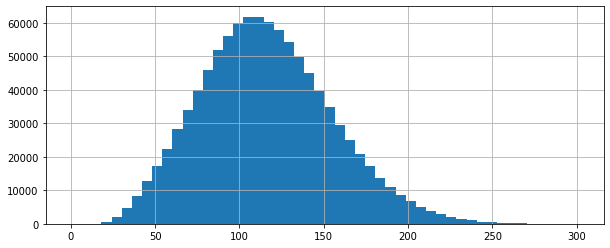

In [10]:
train_salaries.salary.hist(figsize = (10,4), bins=50)

In [11]:
# train_salaries.salary.sort_values().head(20)
zero_salary_jobs = train_salaries.loc[train_salaries.salary == 0, 'jobId']
train_features.loc[train_features.jobId.isin(zero_salary_jobs), :]

# 5 of the jobs have a salary of 0.  This is most likely missing data.  Since it is only 5 out of 1,000,000 rows, deleting these rows will not significantly alter the model.
# Drop rows from training features data set.
train_features.drop(index = zero_salary_jobs.index, axis = 0, inplace = True)

In [12]:
# Drop rows from training salaries data set.
train_salaries.drop(index = zero_salary_jobs.index, axis = 0, inplace = True)

In [13]:
duplicates = train_features.loc[train_features.duplicated(subset=['companyId','jobType','degree','major','industry','yearsExperience','milesFromMetropolis'])]
duplicates.sort_values(by=['companyId','jobType','degree','major','industry','yearsExperience','milesFromMetropolis']).head(20)

# No duplicates across entire rows, even if the jobId is excluded

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
875660,JOB1362685283347,COMP0,CEO,BACHELORS,BIOLOGY,SERVICE,23,34
880977,JOB1362685288664,COMP0,CEO,HIGH_SCHOOL,NONE,AUTO,0,82
876226,JOB1362685283913,COMP0,CEO,HIGH_SCHOOL,NONE,AUTO,15,13
341166,JOB1362684748853,COMP0,CEO,HIGH_SCHOOL,NONE,AUTO,23,94
327150,JOB1362684734837,COMP0,CEO,HIGH_SCHOOL,NONE,EDUCATION,11,63
708731,JOB1362685116418,COMP0,CEO,HIGH_SCHOOL,NONE,FINANCE,18,95
967963,JOB1362685375650,COMP0,CEO,HIGH_SCHOOL,NONE,FINANCE,19,35
999690,JOB1362685407377,COMP0,CEO,HIGH_SCHOOL,NONE,FINANCE,22,32
646028,JOB1362685053715,COMP0,CEO,HIGH_SCHOOL,NONE,FINANCE,23,71
676622,JOB1362685084309,COMP0,CEO,HIGH_SCHOOL,NONE,OIL,10,33


In [14]:
train_features.loc[train_features.companyId == 'COMP0', 'jobType'].value_counts()

# This data set does not have the expected hierarchy among roles (e.g. 1 CEO, 1 CFO, several managers, etc.)

SENIOR            2023
VICE_PRESIDENT    2015
CEO               1976
JUNIOR            1962
CFO               1958
JANITOR           1952
MANAGER           1911
CTO               1869
Name: jobType, dtype: int64

### ---- 4 Explore the data (EDA) ----

In [15]:
#summarize each feature variable
#summarize the target variable
#look for correlation between each feature and the target
#look for correlation between features

In [24]:
# We will combine the train_features and train_salaries data sets to allow for comparison between the features and salary during exploratory data analysis.
train_full = pd.merge(left=train_features, right=train_salaries, how='inner', on='jobId')

In [26]:
train_full.describe(include='all')

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
count,999995,999995,999995,999995,999995,999995,999995.000000,999995.000000,999995.000000
unique,999995,63,8,5,9,7,NaN,NaN,NaN
top,JOB1362684869167,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB,NaN,NaN,NaN
freq,1,16193,125886,236975,532353,143205,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,11.992407,49.529381,116.062398
std,NaN,NaN,NaN,NaN,NaN,NaN,7.212390,28.877721,38.717163
min,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,17.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,6.000000,25.000000,88.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,12.000000,50.000000,114.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,18.000000,75.000000,141.000000


This data set is comprised of 8 different job types (including CEO, VP, Junior, and Janitor) from 63 companies.  The degree field describes the level of the degree: High School, Bachelors, Masters, or Doctoral.  There are also 8 different majors and 7 industries.  The degree and/or major is missing in some cases.  The years of experience range from 0 to 24.  Miles from a metropolis ranges from 0 to 99, indicating the proximity to a city.  Salary is what we aim to predict.  The training data has a wide range of salaries from 17 to 301 (likely in thousands).

In [35]:
print(train_full.industry.value_counts())
# print(len(train_full.jobType.unique()))

WEB          143205
AUTO         142941
FINANCE      142866
EDUCATION    142819
OIL          142770
HEALTH       142755
SERVICE      142639
Name: industry, dtype: int64


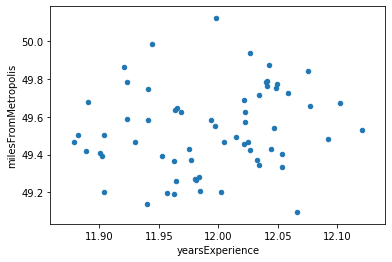

In [58]:
# There are only 3 numeric variables: yearsExperience, milesFromMetropolis, and salary.  Check if there are correlations between them
# train_full.plot.scatter('yearsExperience', 'milesFromMetropolis')

# Too much data to interpret the graph.  Try grouping by company.
train_by_company = train_full.groupby('companyId').mean()
# train_by_company.plot.scatter('yearsExperience', 'milesFromMetropolis')
# train_by_company.plot.scatter('yearsExperience', 'salary')
# train_by_company.plot.scatter('milesFromMetropolis', 'salary')

# Try taking a sample of the data set.
sample_train = train_full.sample(frac=.0001)
# sample_train.plot.scatter('yearsExperience', 'milesFromMetropolis')
# sample_train.plot.scatter('yearsExperience', 'salary')
# sample_train.plot.scatter('milesFromMetropolis', 'salary')

# There is no correlation between yearsExperience and milesFromMetropolis, which means they are independent and can both be used in a model.
# There is a slightly positive correlation between yearsExperience and salary, and a slightly negative correlation between milesFromMetropolis and salary.

<bound method Grid.add_legend of <seaborn.axisgrid.FacetGrid object at 0x7fda8bef74d0>>

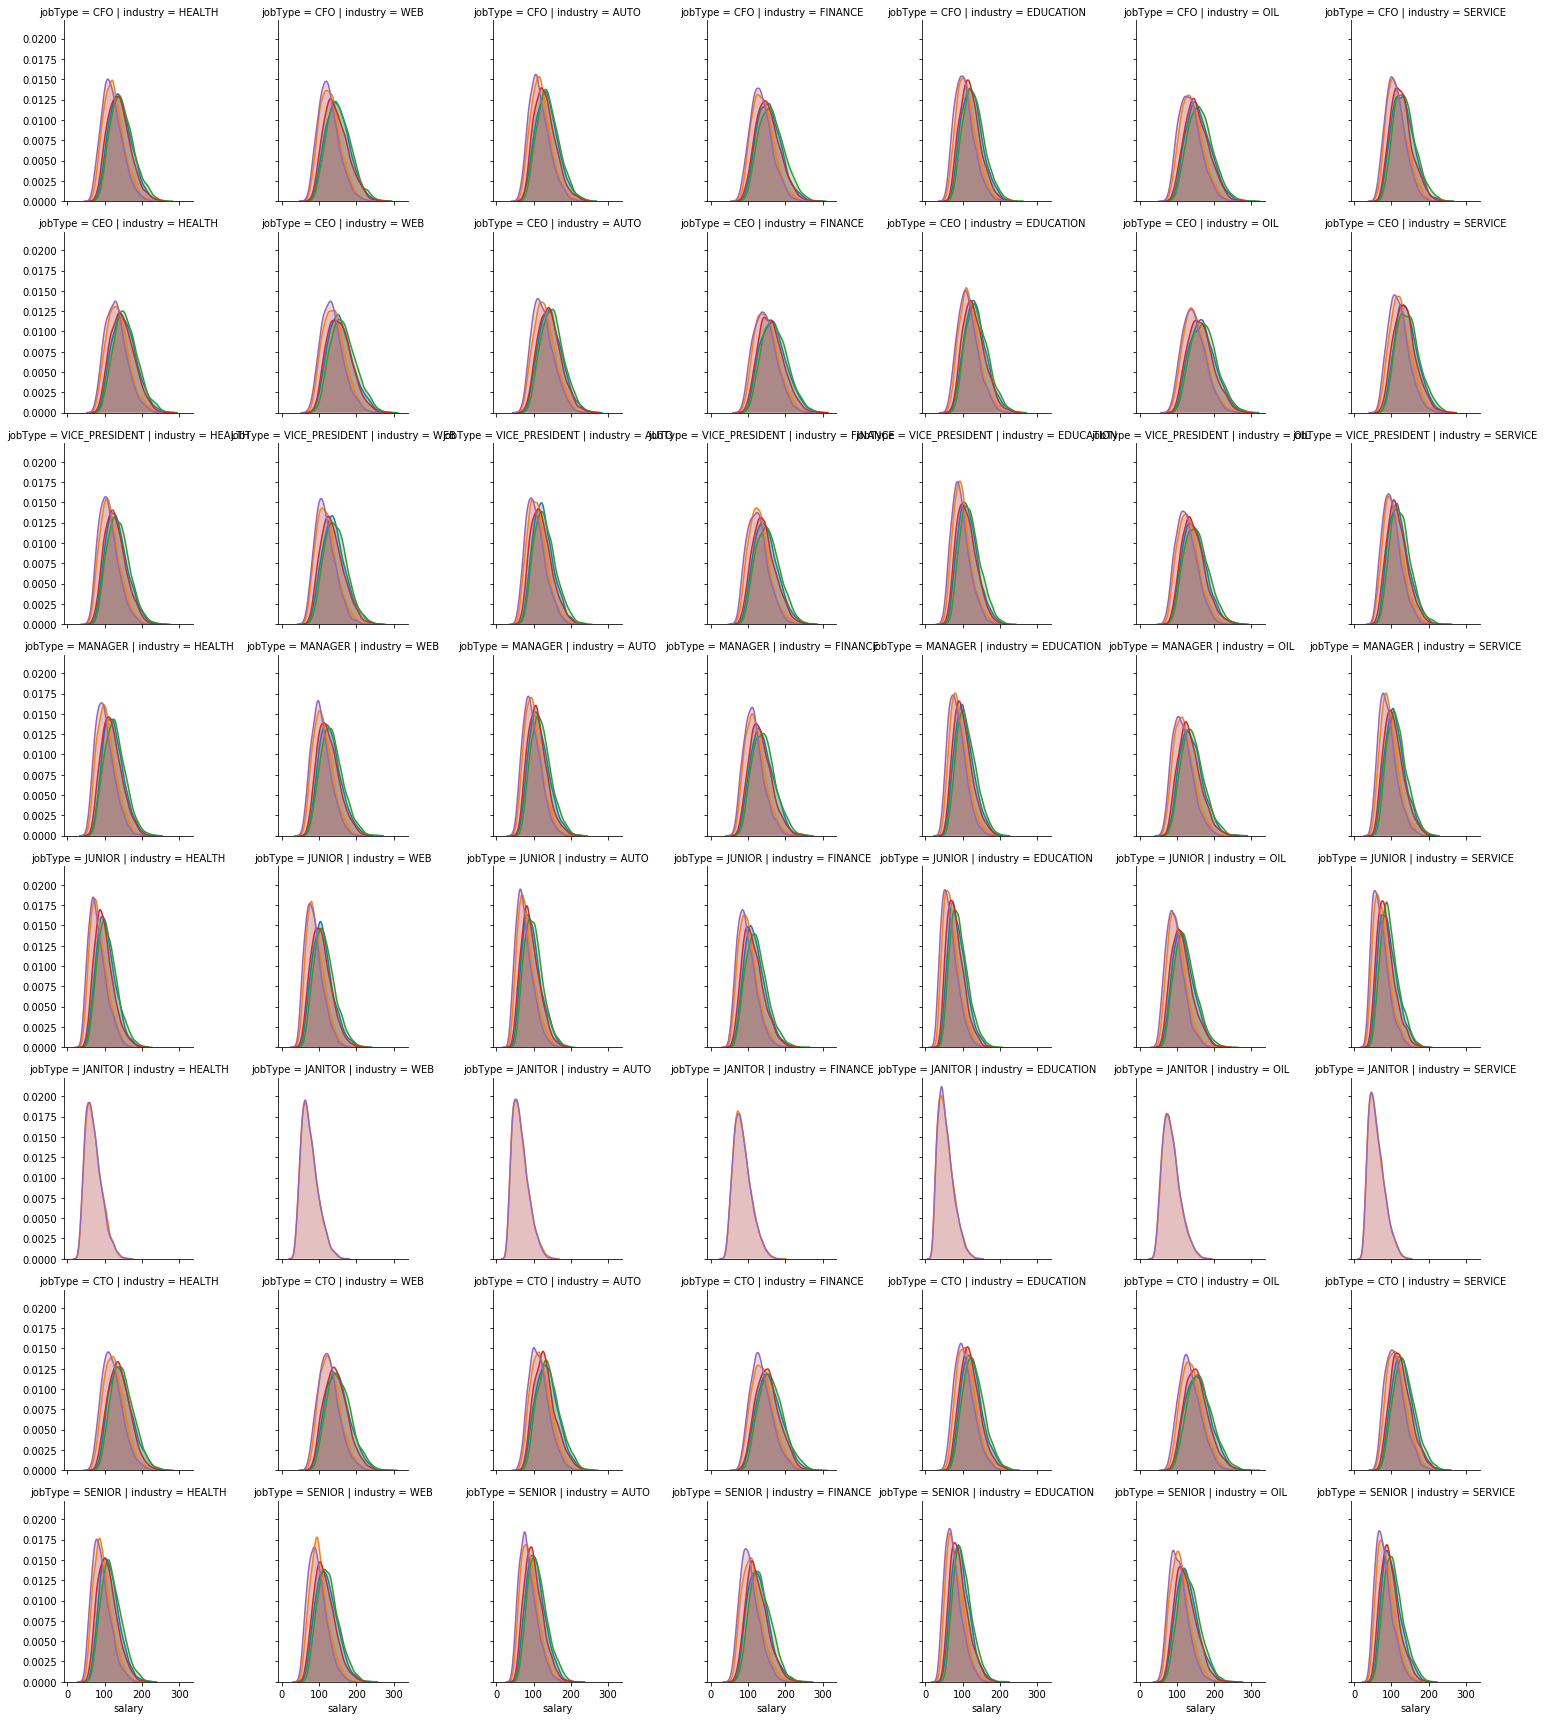

In [62]:
# Explore categorical variables using seaborn's FacetGrid
g = sns.FacetGrid(train_full, col='industry', row='jobType', hue='degree')
g.map(sns.kdeplot, 'salary', shade=True)
g.add_legend

Higher level roles like CEO, CFO and CTO usually earn the highest salaries, janitors the lowest.  Janitors only have a high school degree.  There is slight variation among industries, but nothing stands out.

### ---- 5 Establish a baseline ----

In [16]:
#select a reasonable metric (MSE in this case)
#create an extremely simple model and measure its efficacy
#e.g. use "average salary" for each industry as your model and then measure MSE
#during 5-fold cross-validation

### ---- 6 Hypothesize solution ----

In [17]:
#brainstorm 3 models that you think may improve results over the baseline model based
#on your 

Brainstorm 3 models that you think may improve results over the baseline model based on your EDA and explain why they're reasonable solutions here.

Also write down any new features that you think you should try adding to the model based on your EDA, e.g. interaction variables, summary statistics for each group, etc

## Part 3 - DEVELOP

You will cycle through creating features, tuning models, and training/validing models (steps 7-9) until you've reached your efficacy goal

#### Your metric will be MSE and your goal is:
 - <360 for entry-level data science roles
 - <320 for senior data science roles

### ---- 7 Engineer features  ----

In [18]:
#make sure that data is ready for modeling
#create any new features needed to potentially enhance model

### ---- 8 Create models ----

In [19]:
#create and tune the models that you brainstormed during part 2

### ---- 9 Test models ----

In [20]:
#do 5-fold cross validation on models and measure MSE

### ---- 10 Select best model  ----

In [21]:
#select the model with the lowest error as your "prodcuction" model

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [22]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset

### ---- 12 Deploy solution ----

In [23]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders

### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data